# kernel_scan Quick Start

This notebook demonstrates how to use the kernel_scan library to profile GEMM operations and analyze performance with roofline models.

In [3]:
import sys
from pathlib import Path

# Add the src directory to sys.path to import kernel_scan
# Note: This is only needed when running from the repository
project_root = Path.cwd().parent.parent.parent
src_path = project_root / "src"
sys.path.append(str(src_path))

from kernel_scan.core.logging import configure_logging, get_logger
from kernel_scan.api.operations.gemm import GemmScan, GemmPlotter
from kernel_scan.core.types import DataType, EngineType

import polars as pl

# Configure logging with desired level
configure_logging(level="debug")
log = get_logger("quickstart")

## Configure and Run a GEMM Scan

We'll configure a simple GEMM scan with:
- Data Type: FLOAT16
- M values: 1, 2
- N values: 64, 128
- K = N for all test cases

In [ ]:
# Initialize the GemmScan object with default parameters
scan = GemmScan()

# Configure and run the scan using the fluent API
results = (
    scan
    .with_engine_type(EngineType.COMPOSABLE_KERNEL)
    #.with_data_types([ DataType.FLOAT16]) # TESTING
    # .for_n_values([2**n for n in range(6, 8)])  # TESTING
    # .for_m_values([2**n for n in range(0, 3)])  # TESTING
    .with_data_types([ DataType.FLOAT16, DataType.BFLOAT16, DataType.FLOAT32])
    .for_n_values([2**n for n in range(6, 15)])  # powers of 2 from 2⁶ to 2¹⁴
    .for_m_values([2**n for n in range(0, 9)])  # powers of 2 from 2⁰ to 2⁸
    .with_k_equals_n()  # Configure the scan to use K = N for all test cases
    .iterations(10)
    .warmup(5)
    .run()
)

## Generate Roofline Plots

Now we'll use the new GemmPlotter class to generate roofline plots for our results.

In [5]:
result_sets = []
for data_type, result_sets in results.items():
    print(data_type, len(result_sets))
    result_sets += result_sets

FLOAT16 81
BFLOAT16 81
FLOAT32 81


In [6]:
len(result_sets)

162

In [7]:
dfs = [rs.results_as_dataframe for rs in result_sets] 

In [8]:
combined = pl.concat(dfs)

In [9]:
display(combined)

shape: (1_776, 7)
┌─────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ is_best ┆ latency_valu ┆ latency_unit ┆ memory_bandw ┆ memory_bandw ┆ compute_perf ┆ compute_per │
│ ---     ┆ e            ┆ ---          ┆ idth_value   ┆ idth_unit    ┆ ormance_valu ┆ formance_un │
│ bool    ┆ ---          ┆ str          ┆ ---          ┆ ---          ┆ e            ┆ it          │
│         ┆ f64          ┆              ┆ f64          ┆ str          ┆ ---          ┆ ---         │
│         ┆              ┆              ┆              ┆              ┆ f64          ┆ str         │
╞═════════╪══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ false   ┆ 10.7946      ┆ μs           ┆ 1.89725      ┆ GB/s         ┆ 6.07121      ┆ GFLOP/s     │
│ true    ┆ 10.5969      ┆ μs           ┆ 1.93263      ┆ GB/s         ┆ 6.18443      ┆ GFLOP/s     │
│ false   ┆ 11.4534      ┆ μs           ┆ 1.78812      ┆ GB/s         ┆ 5.72199      ┆ GFLOP/s     │
│ false   ┆ 11.4382      ┆ μs           ┆ 1.7905       ┆ GB/s         ┆ 5.72959      ┆ GFLOP/s     │
│ false   ┆ 11.4246      ┆ μs           ┆ 1.79263      ┆ GB/s         ┆ 5.73641      ┆ GFLOP/s     │
│ …       ┆ …            ┆ …            ┆ …            ┆ …            ┆ …            ┆ …           │
│ false   ┆ 109433.0     ┆ μs           ┆ 10.1185      ┆ GB/s         ┆ 1255.92      ┆ GFLOP/s     │
│ false   ┆ 109185.0     ┆ μs           ┆ 10.1415      ┆ GB/s         ┆ 1258.78      ┆ GFLOP/s     │
│ false   ┆ 109647.0     ┆ μs           ┆ 10.0988      ┆ GB/s         ┆ 1253.47      ┆ GFLOP/s     │
│ false   ┆ 13008.4      ┆ μs           ┆ 85.1218      ┆ GB/s         ┆ 10565.4      ┆ GFLOP/s     │
│ true    ┆ 12907.9      ┆ μs           ┆ 85.7844      ┆ GB/s         ┆ 10647.7      ┆ GFLOP/s     │
└─────────┴──────────────┴──────────────┴──────────────┴──────────────┴──────────────┴─────────────┘

In [ ]:
roofline_data_list = []
for rs in result_sets:
    rf_df = GemmPlotter.calculate_roofline_data(rs)
    roofline_data_list.append(rf_df)

In [11]:
roofline_combined = pl.concat(roofline_data_list)

In [12]:
(
    roofline_combined
    .unique(pl.col("m"))
    .sort(pl.col("m"))
    .select("m")
)

shape: (6, 1)
┌─────┐
│ m   │
│ --- │
│ i32 │
╞═════╡
│ 8   │
│ 16  │
│ 32  │
│ 64  │
│ 128 │
│ 256 │
└─────┘

In [ ]:
# Use the GemmPlotter class to generate plots
figures = []
for data_type, result_sets in results.items():
    plots_by_m = GemmPlotter.generate_roofline_plots_by_group(result_sets, "m")
    figures.append(plots_by_m)

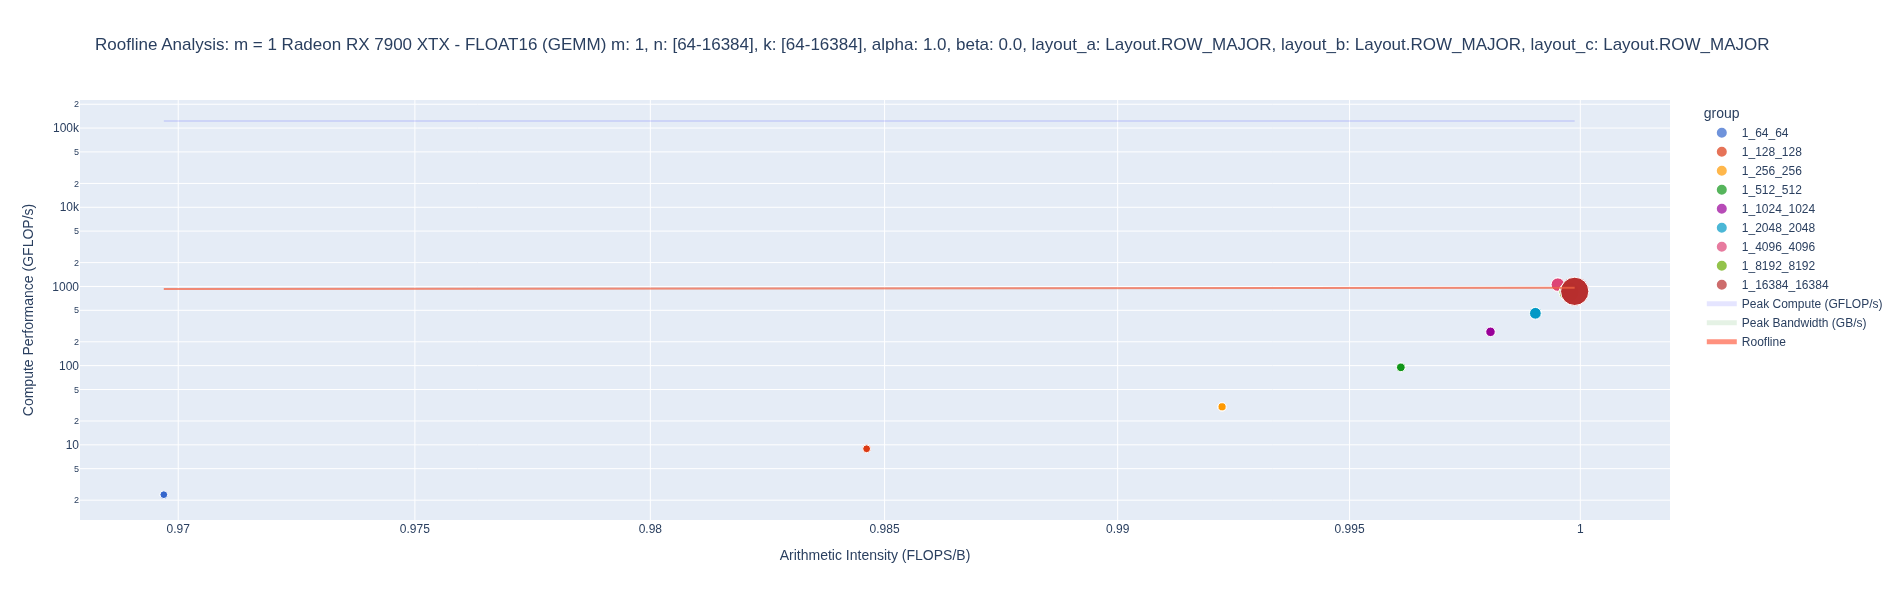

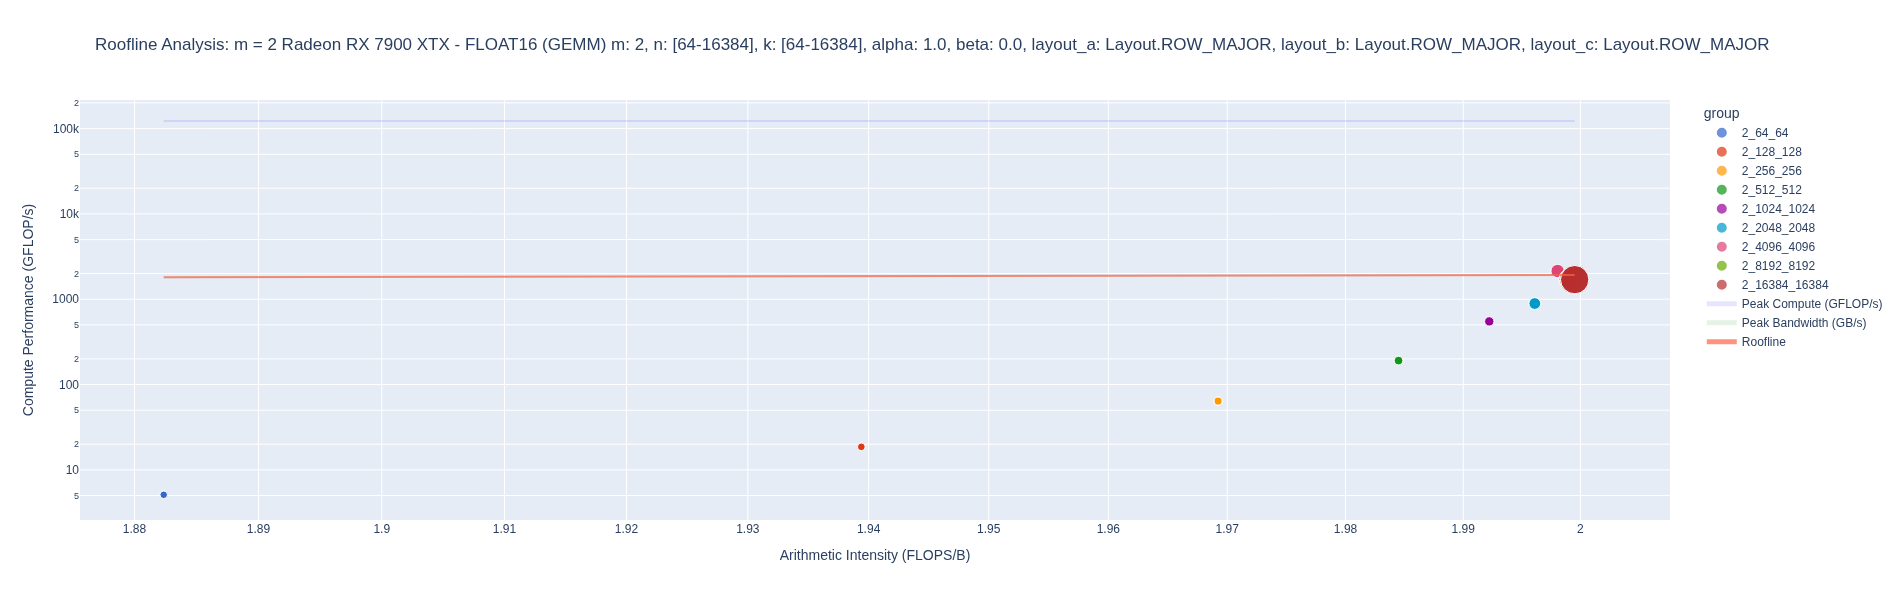

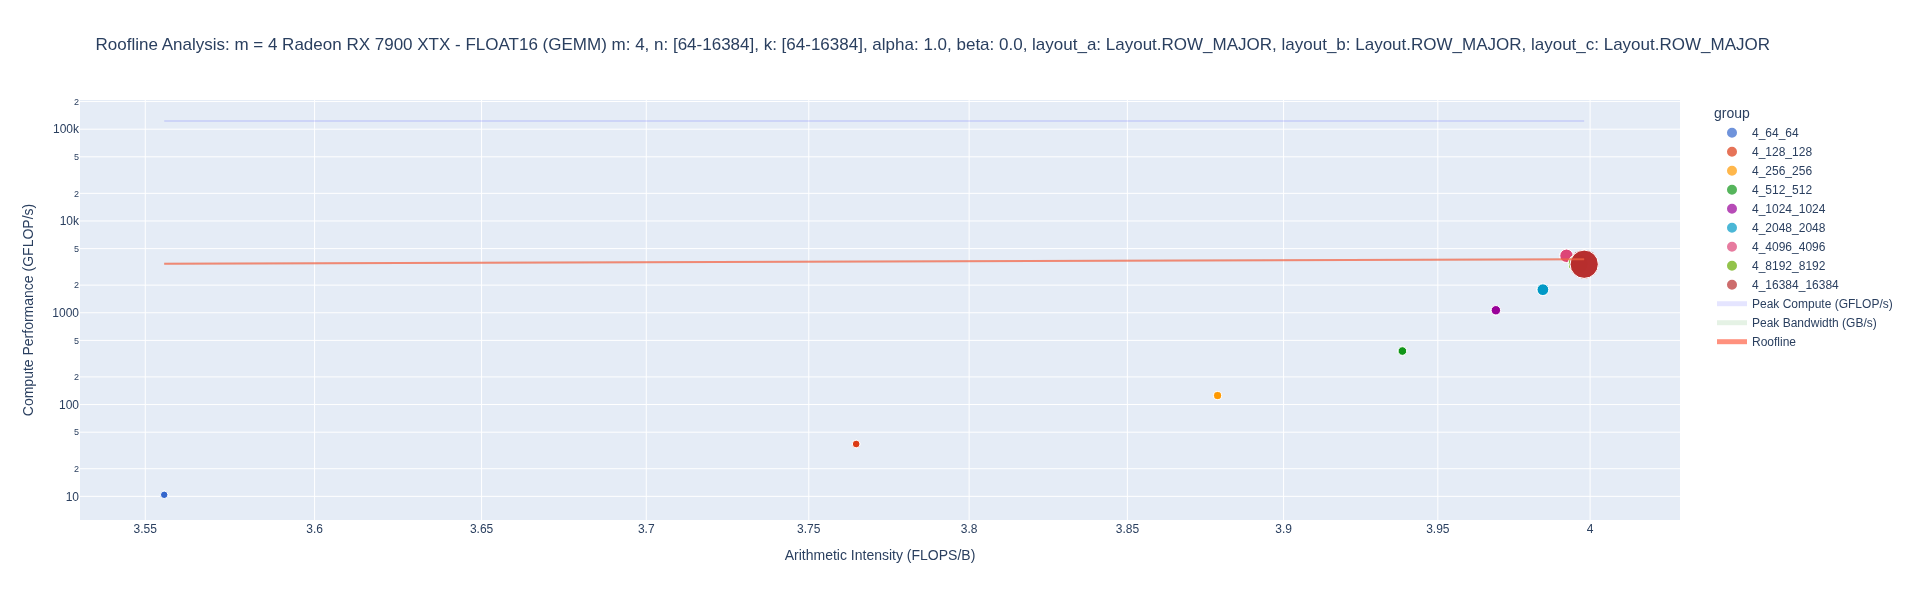

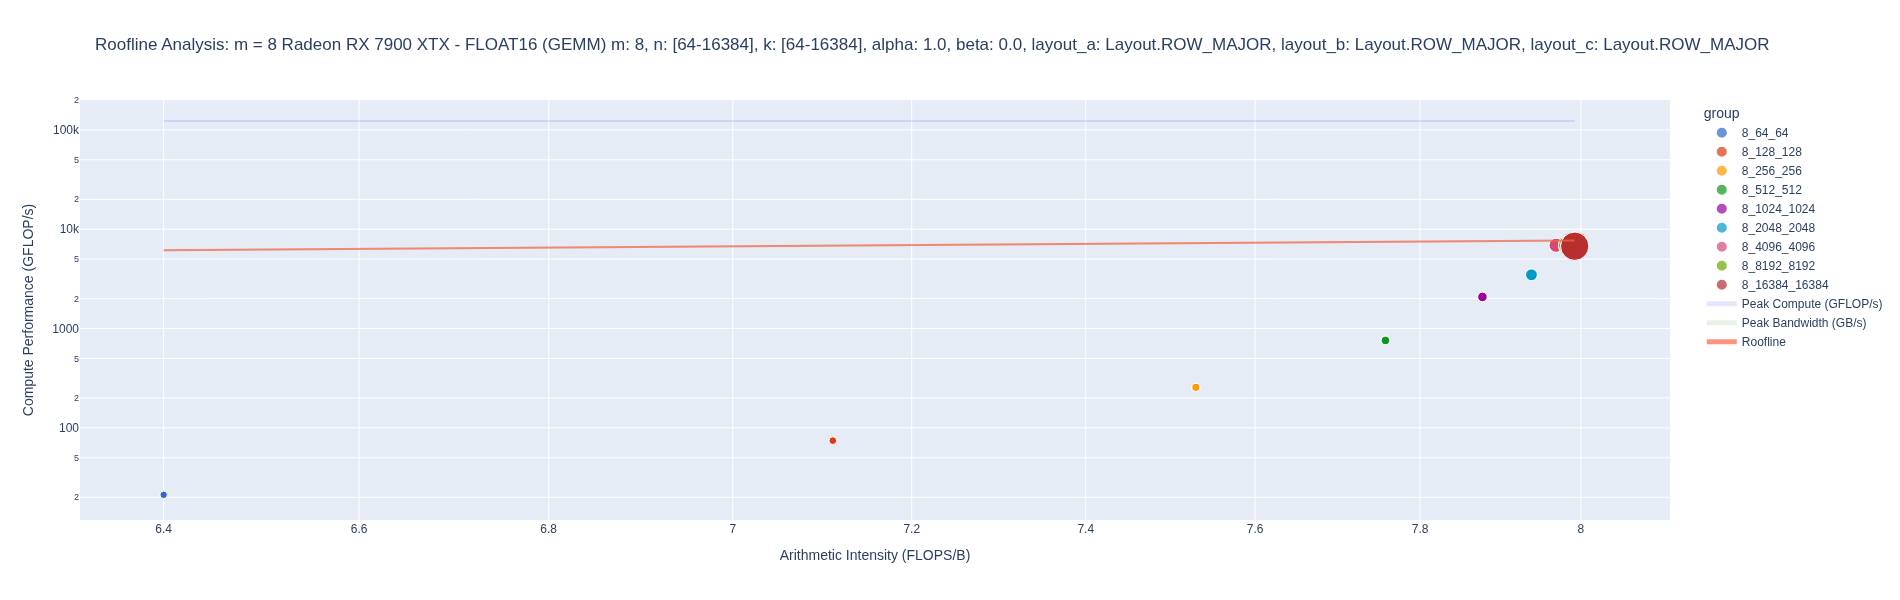

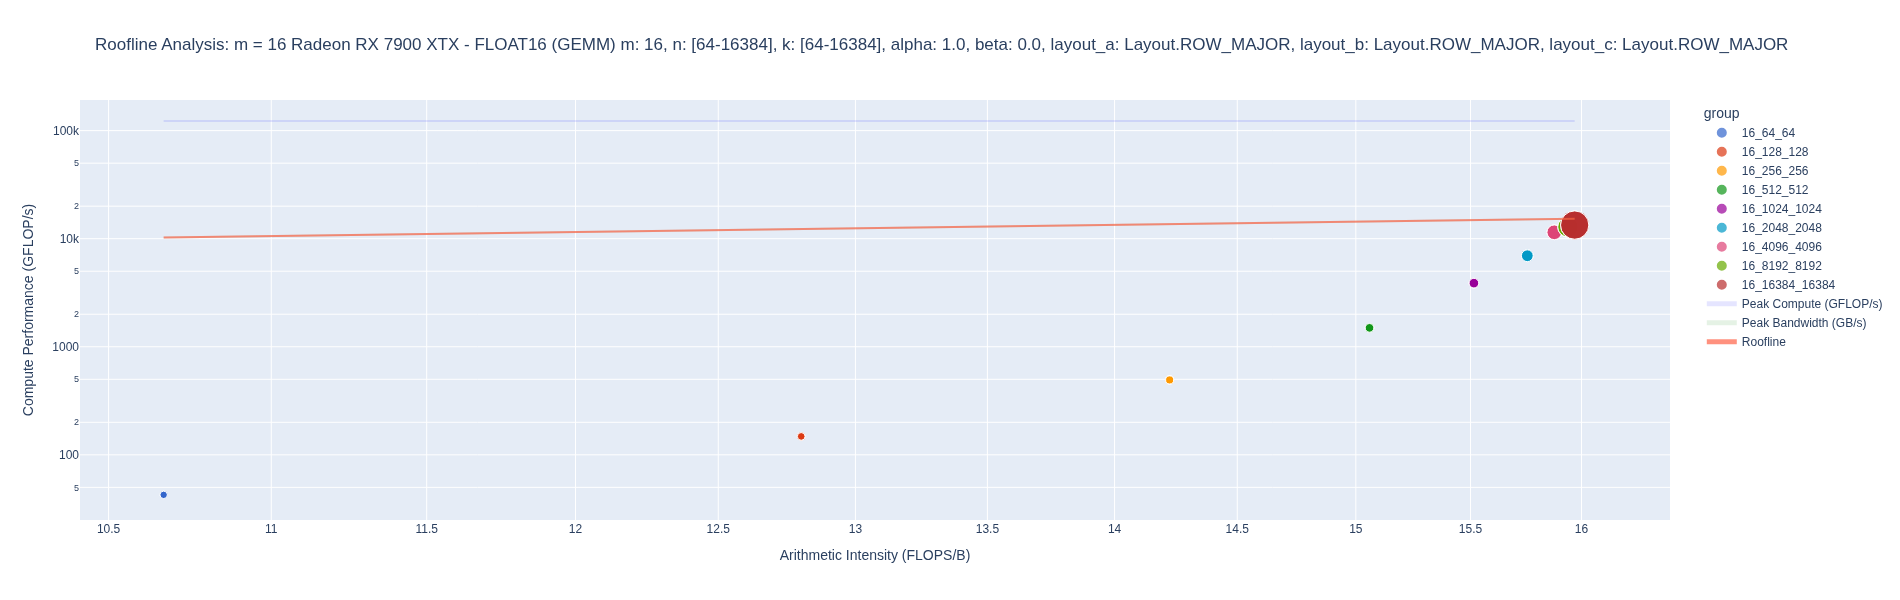

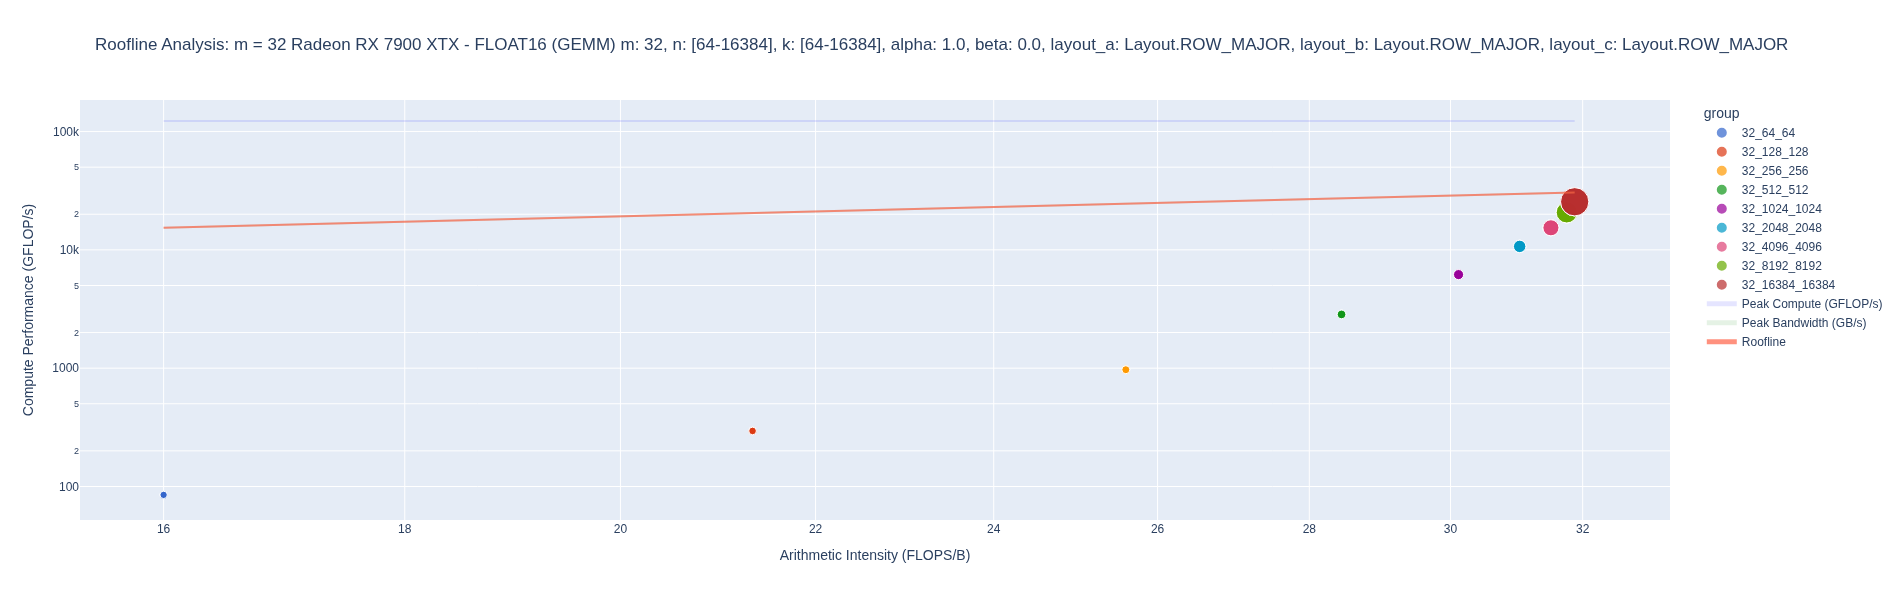

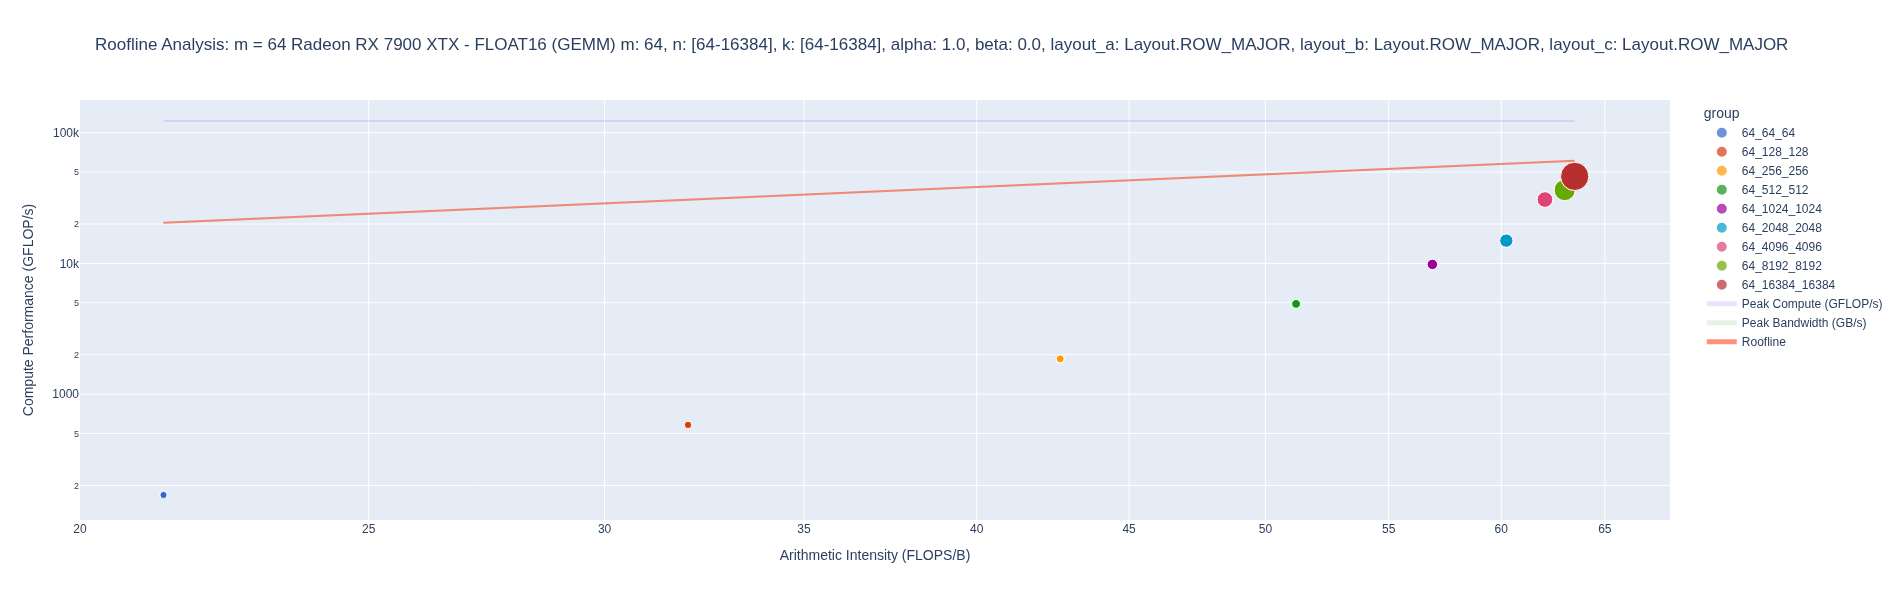

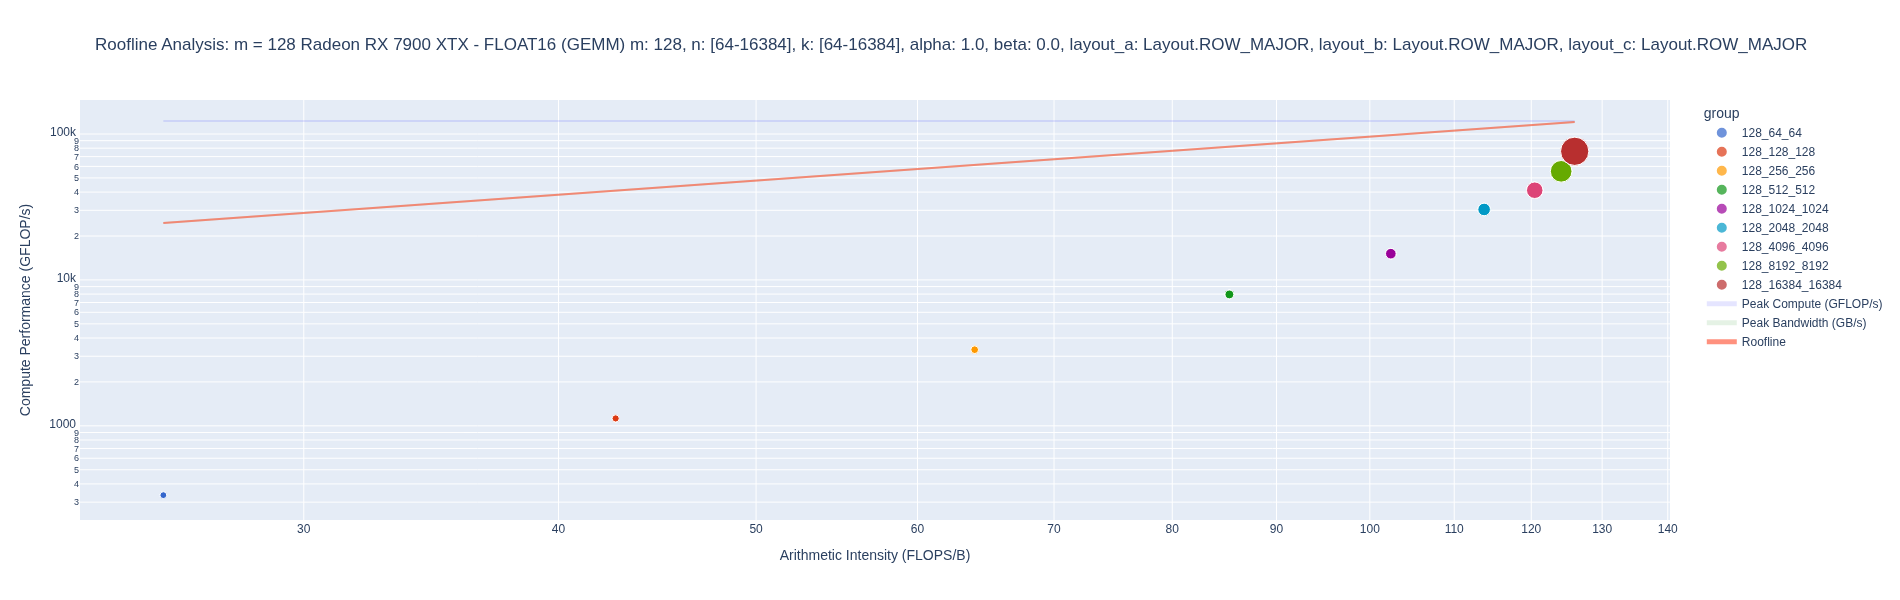

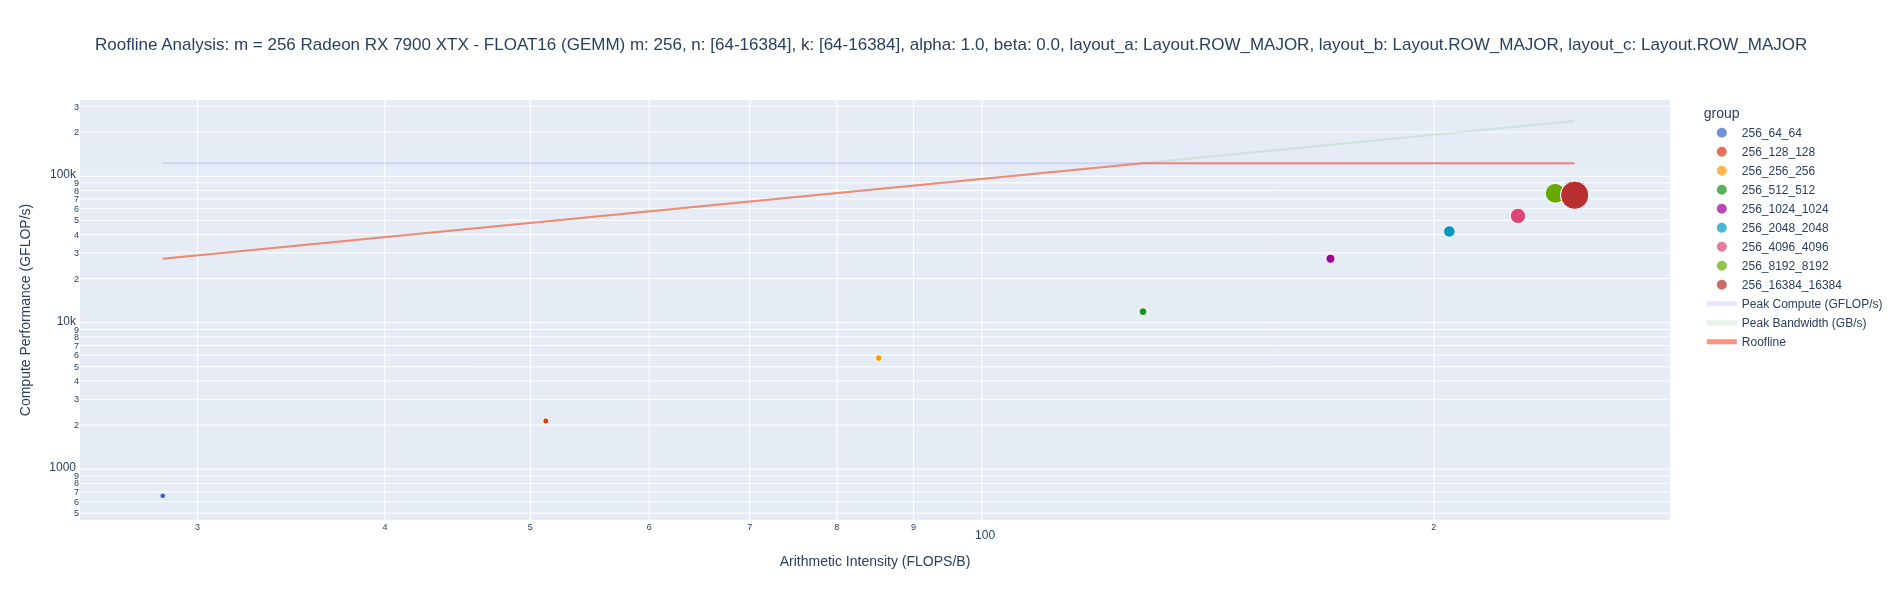

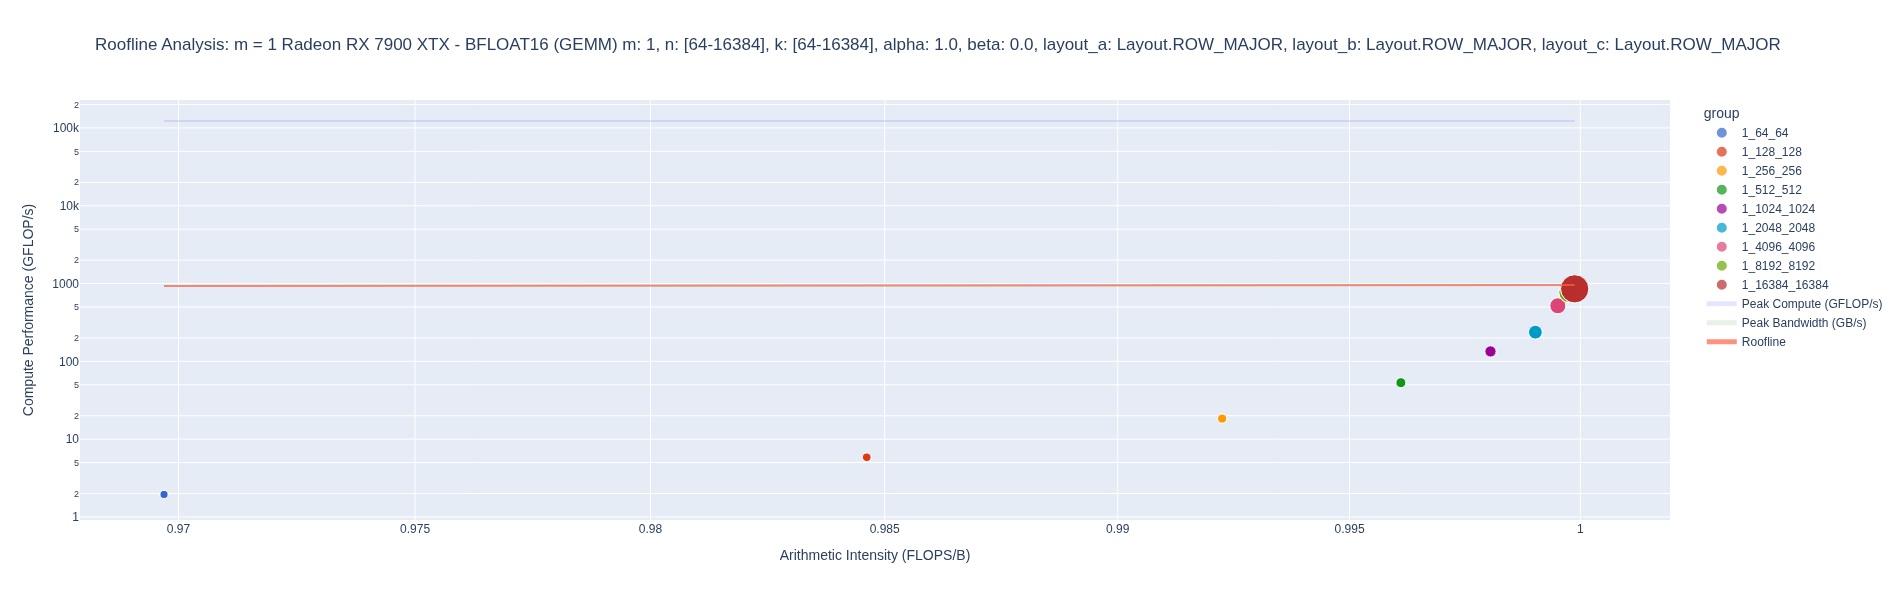

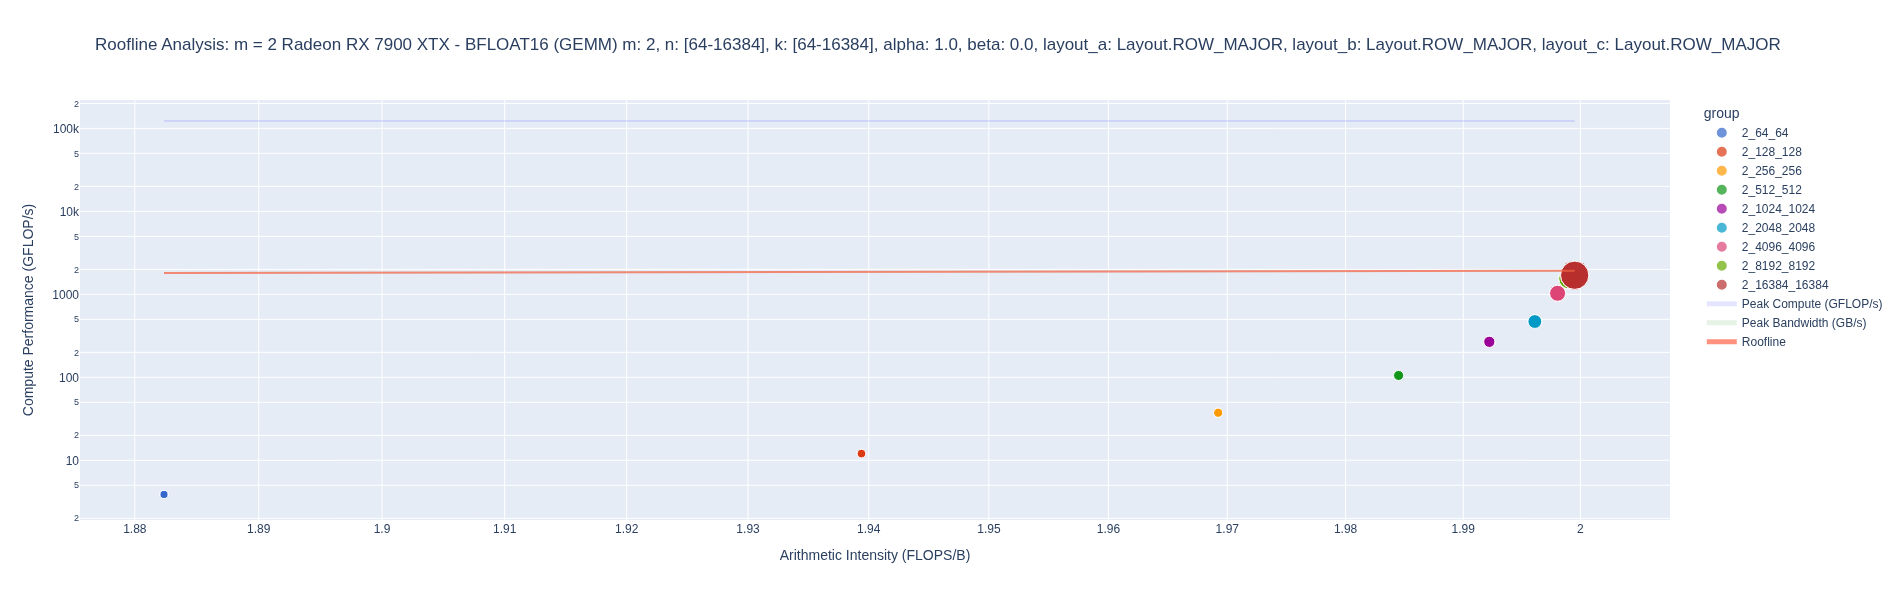

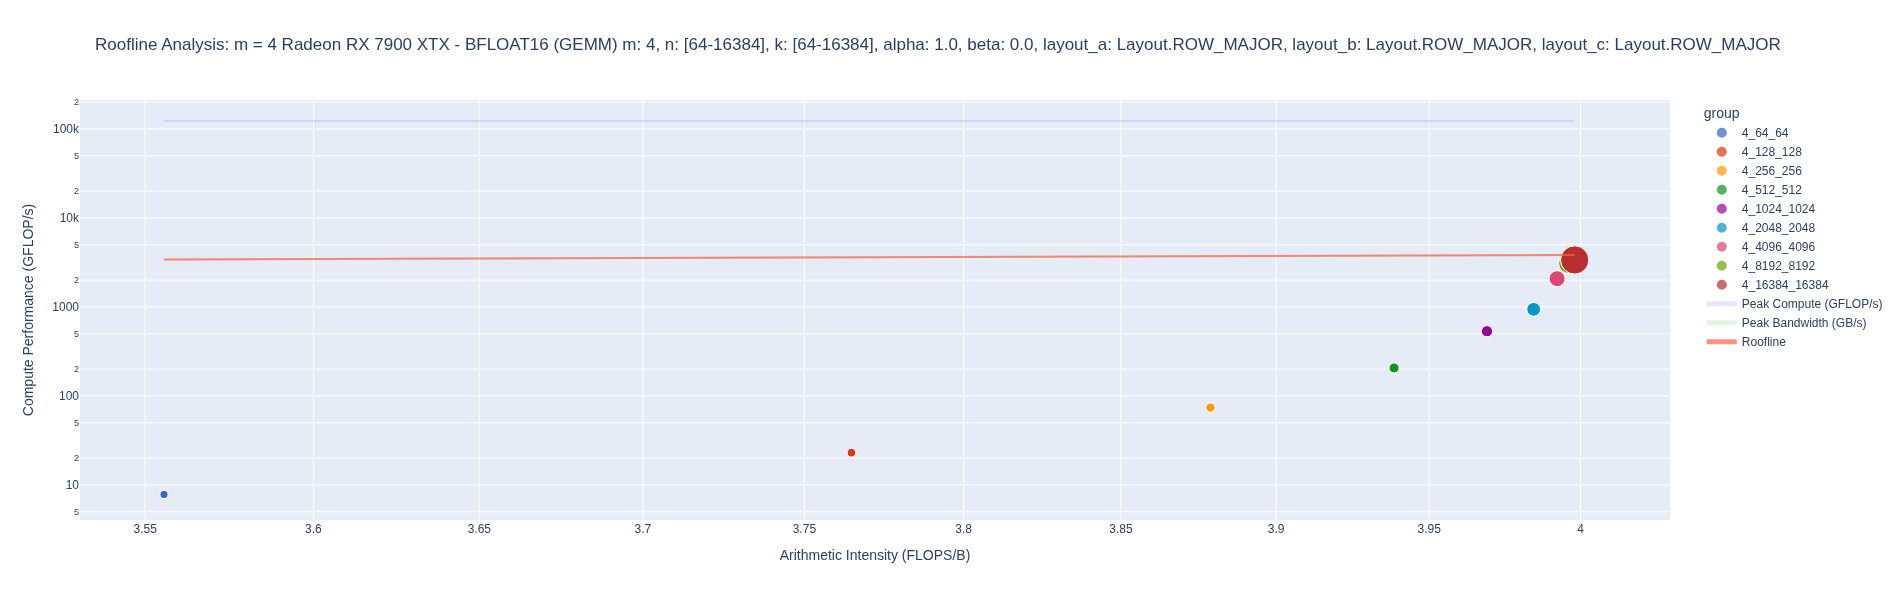

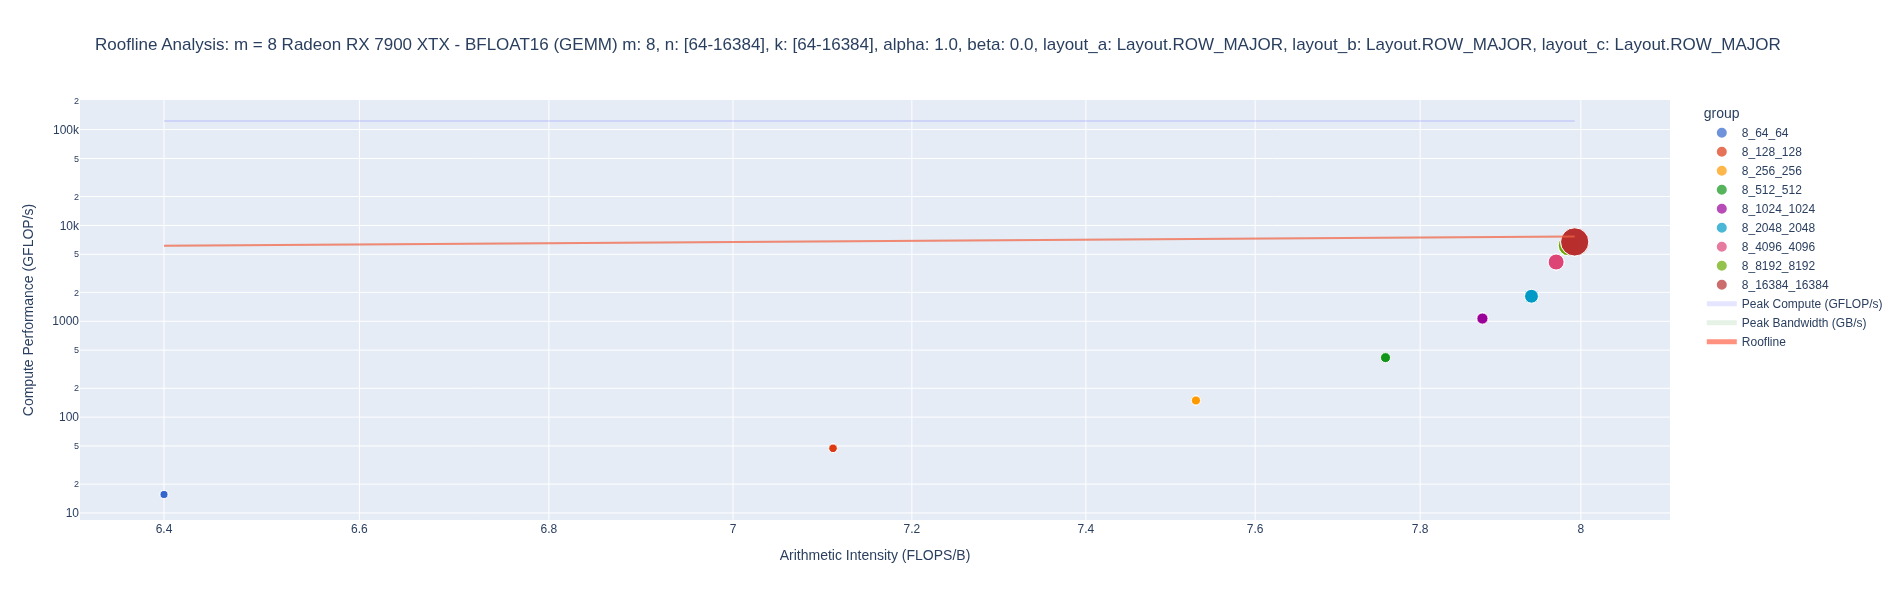

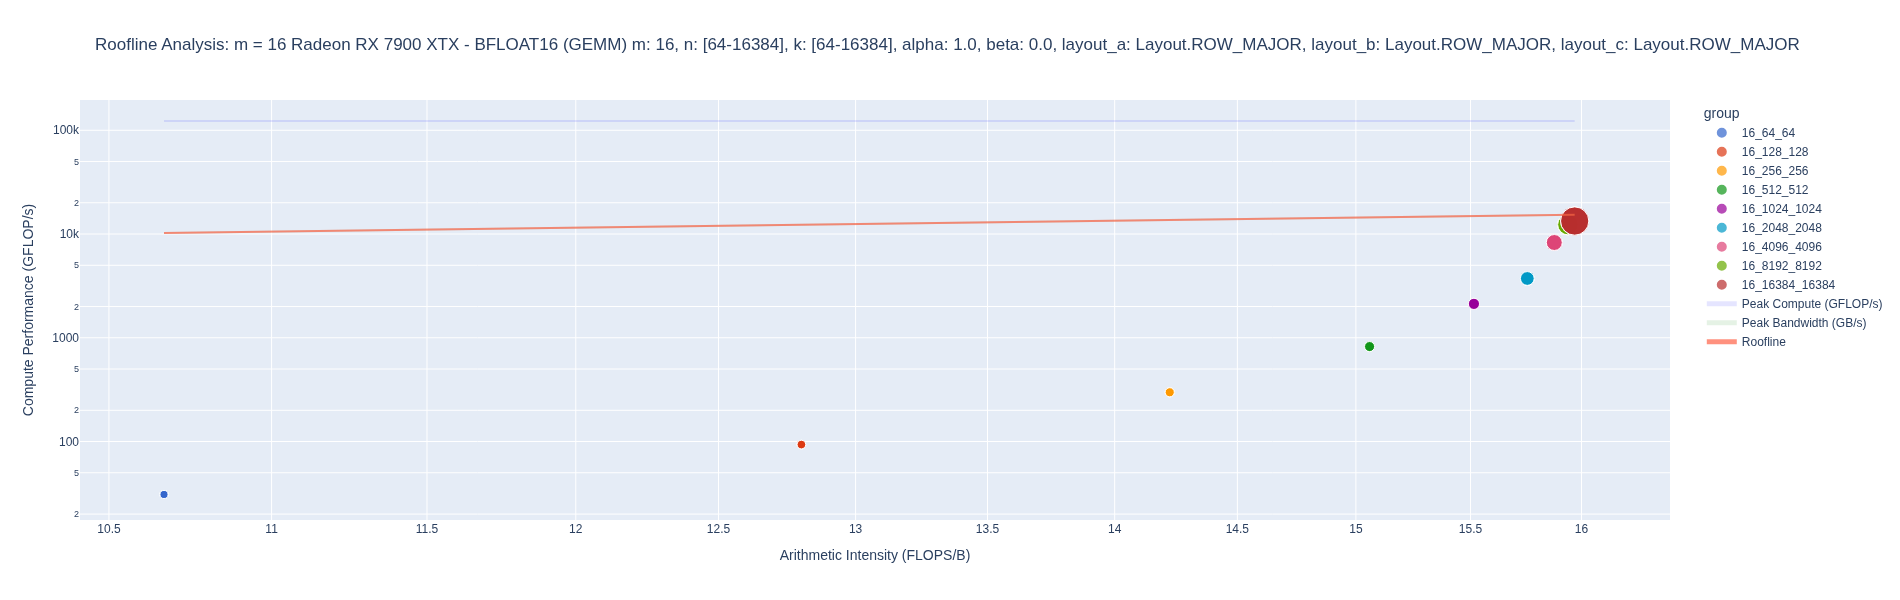

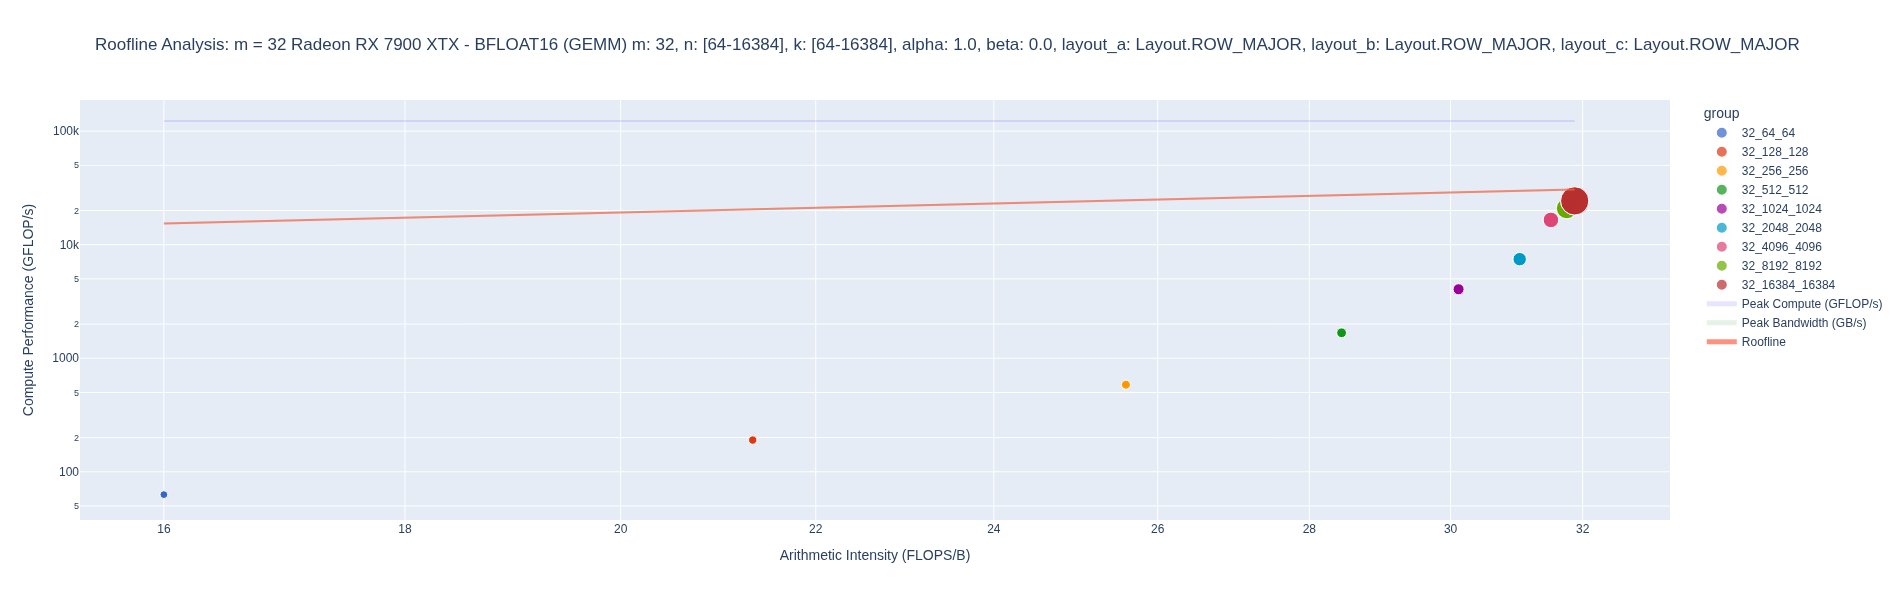

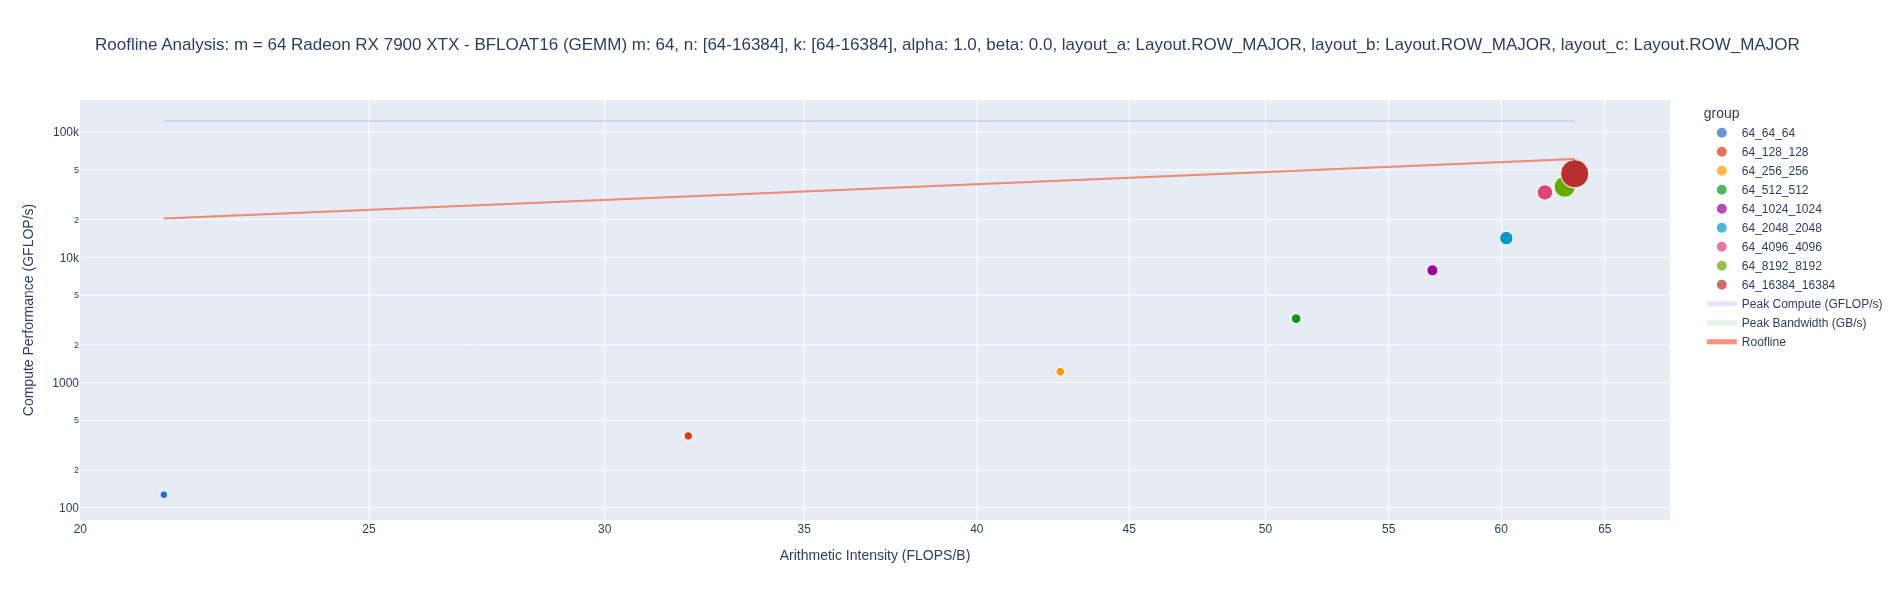

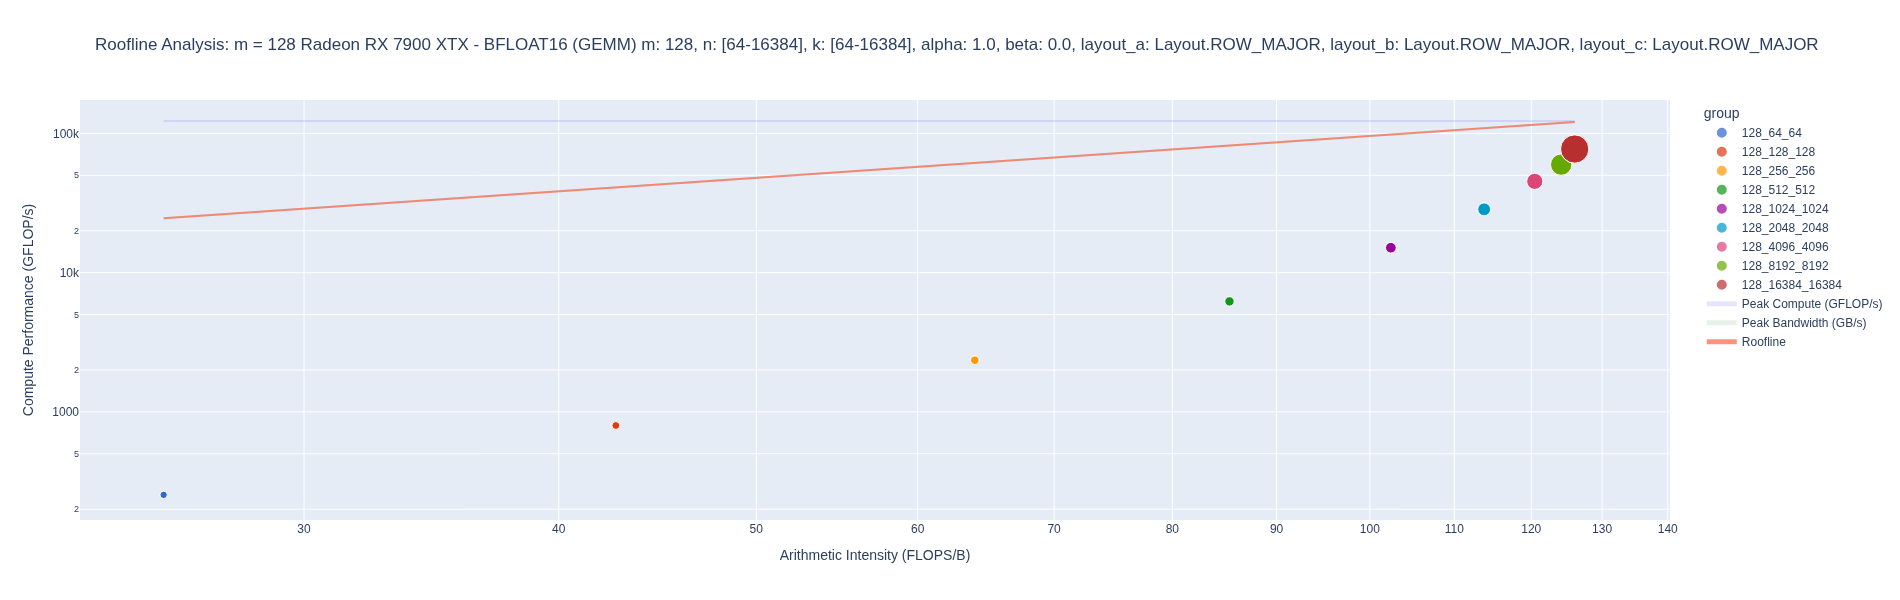

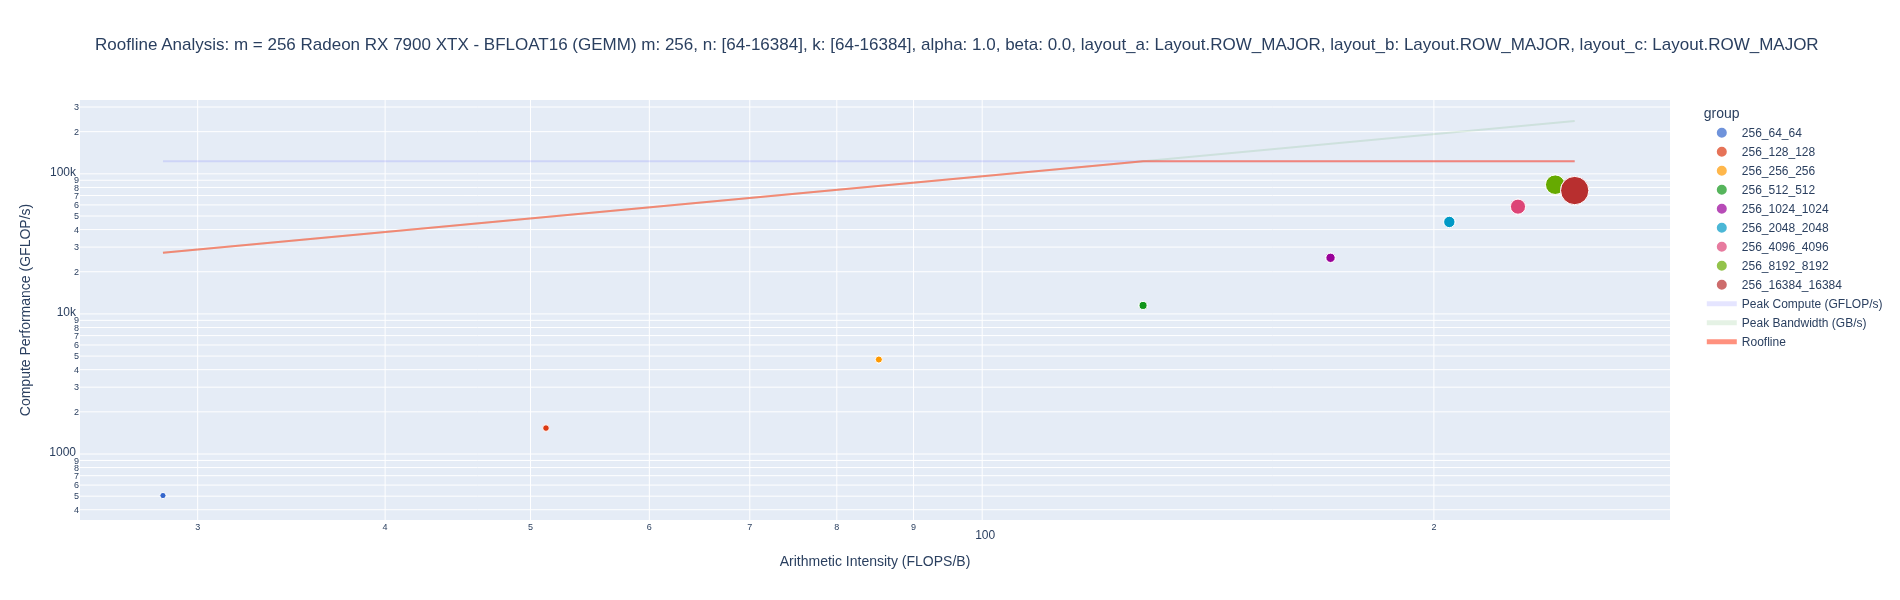

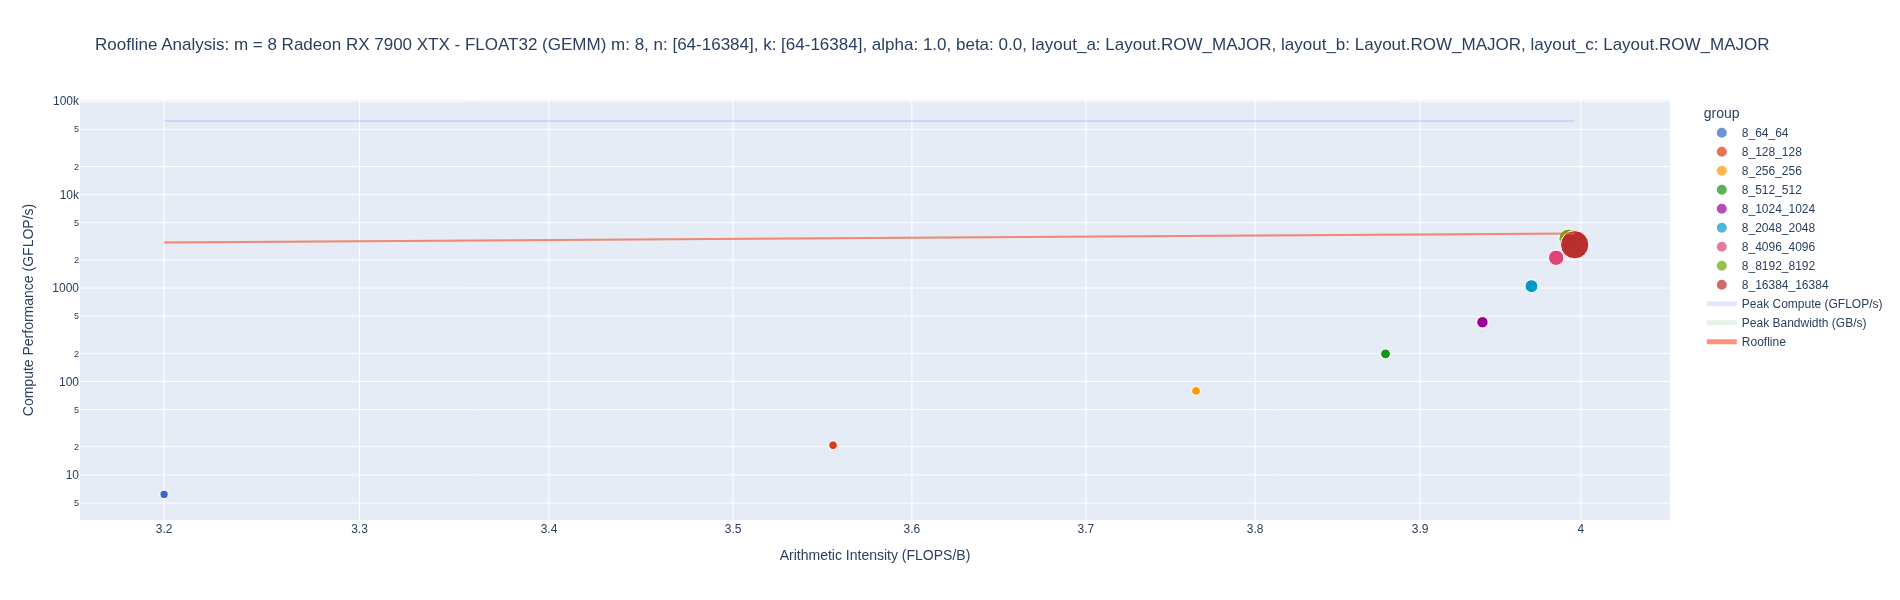

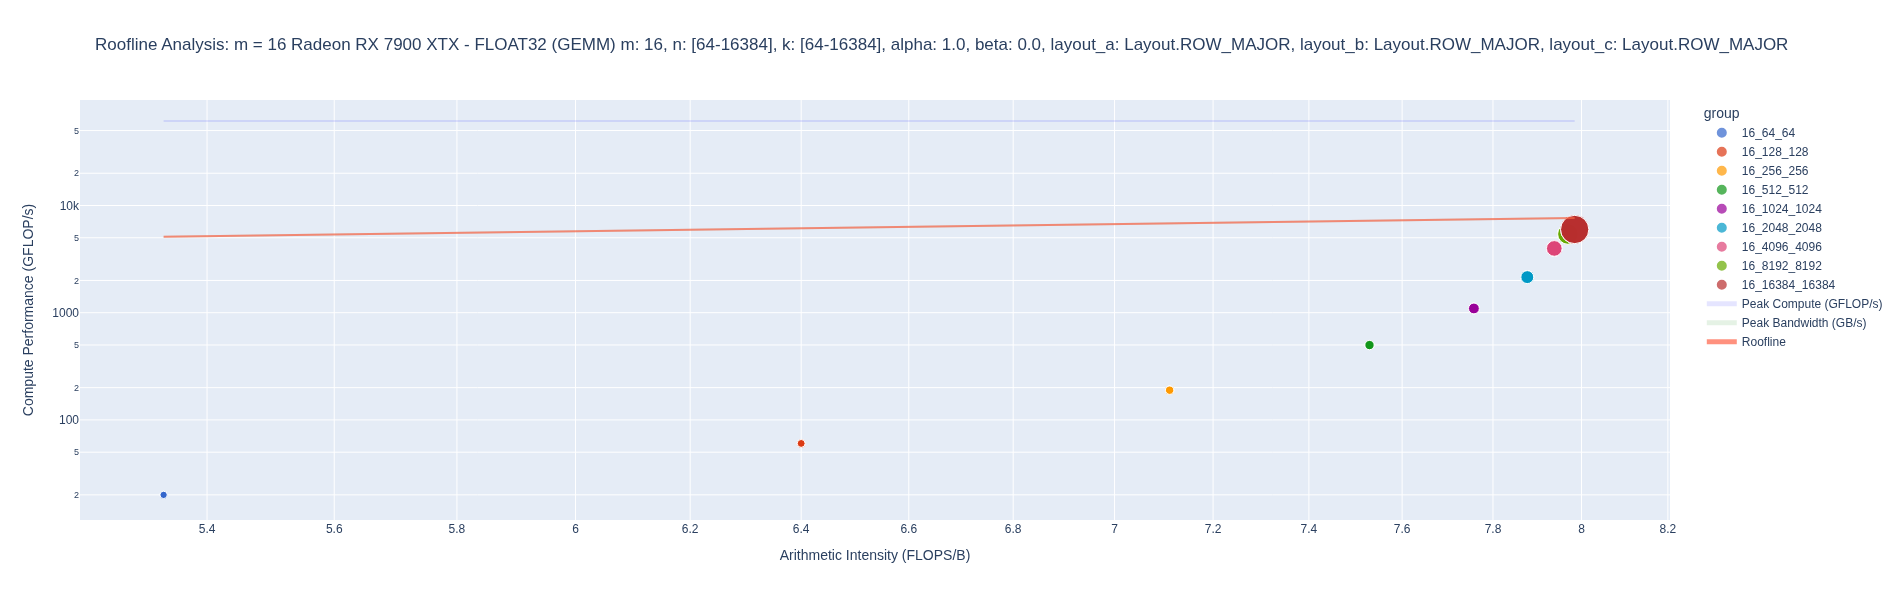

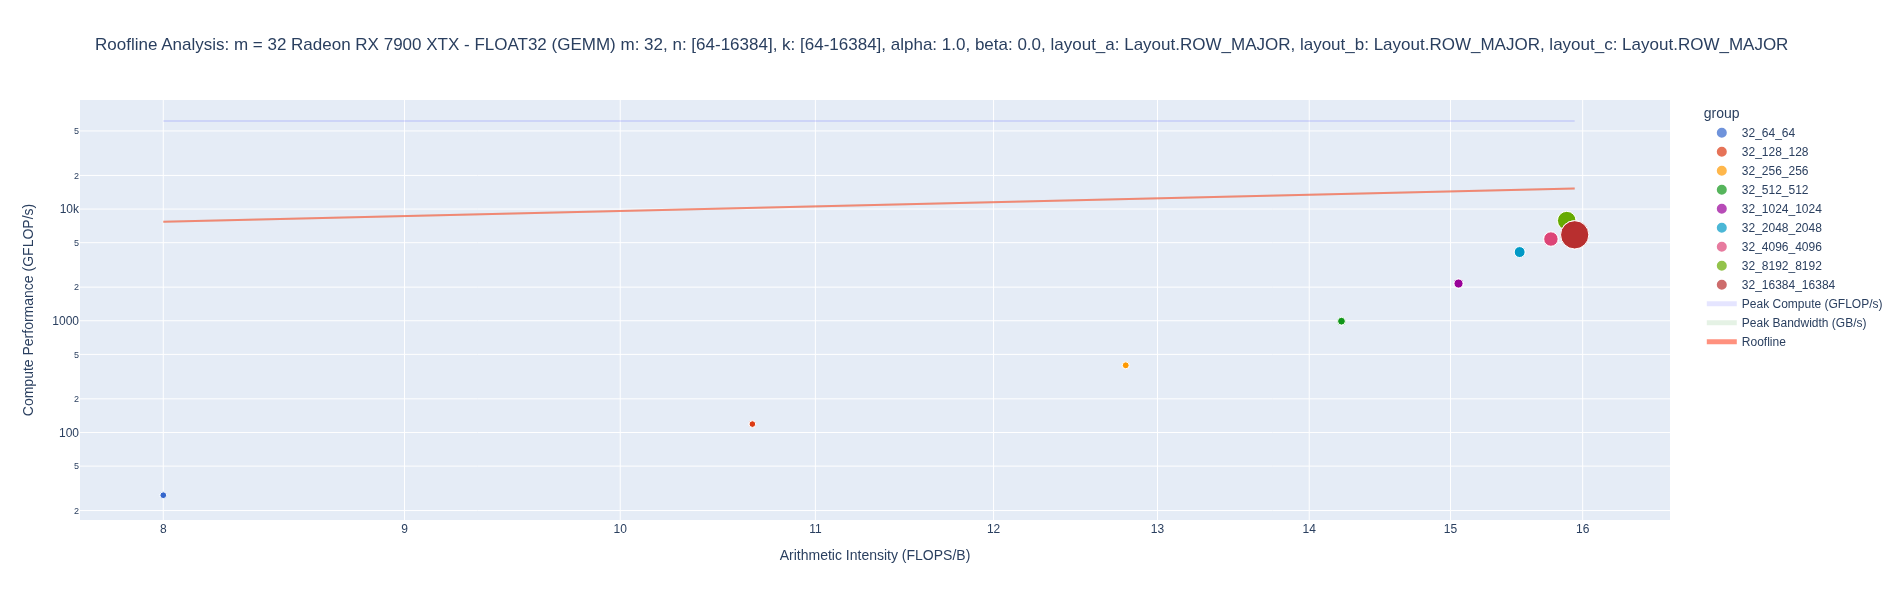

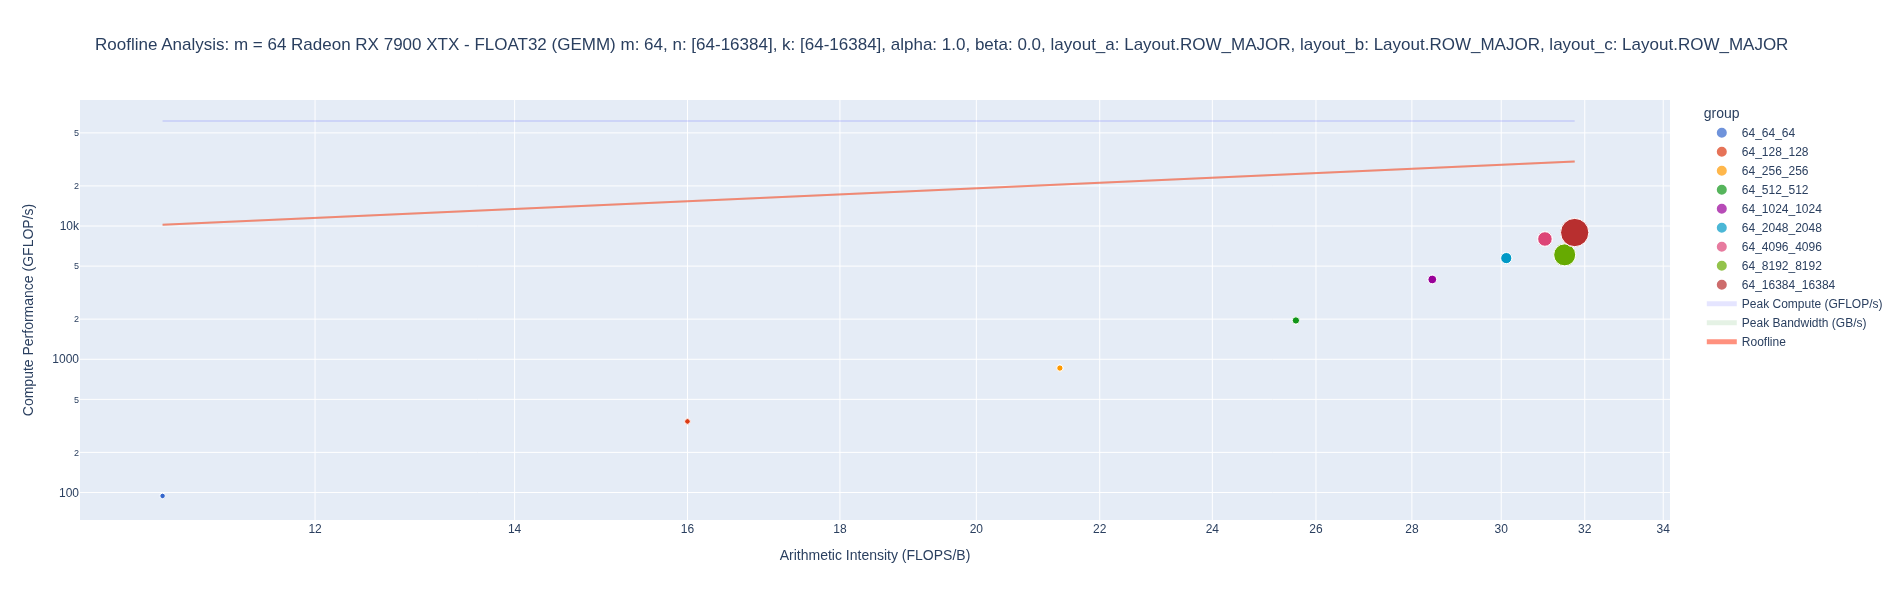

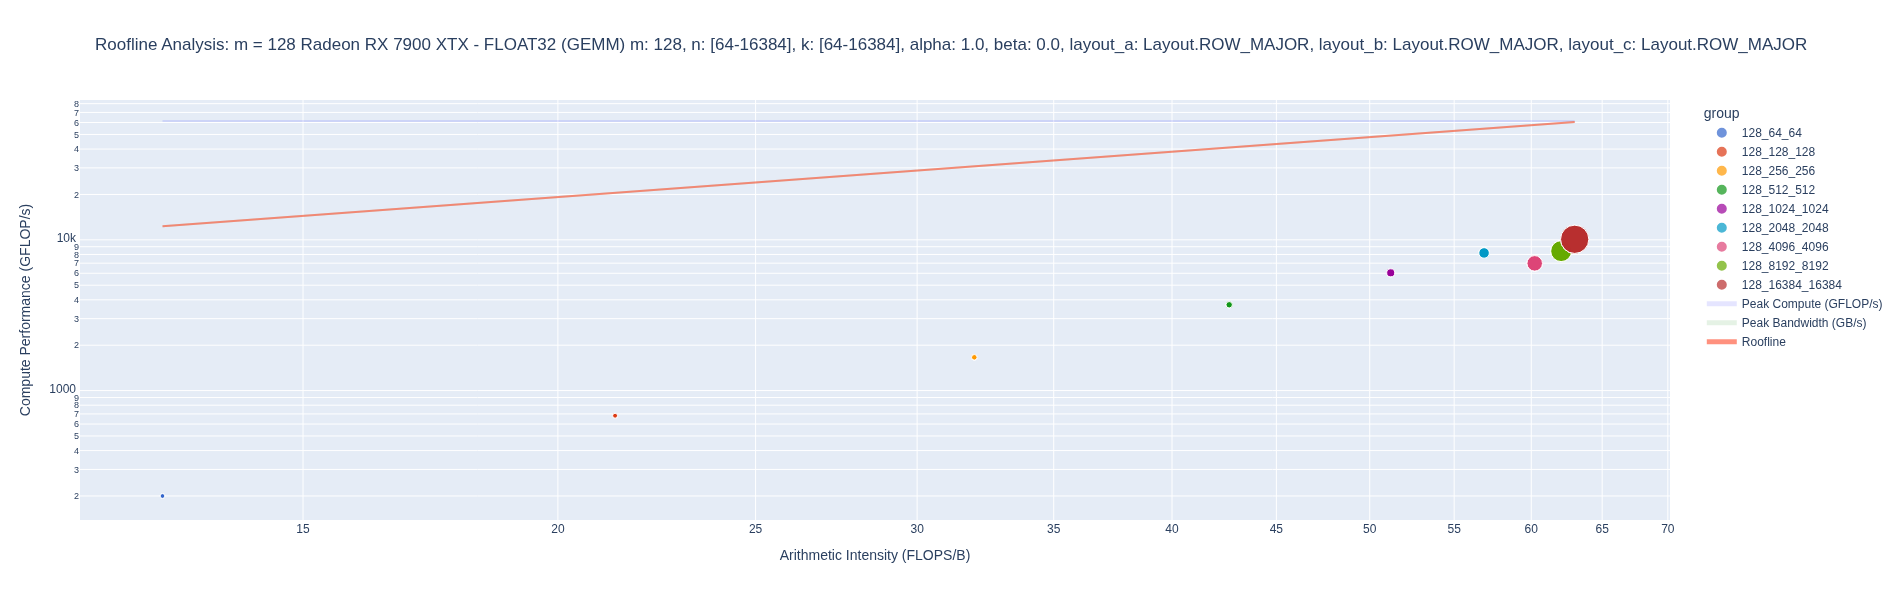

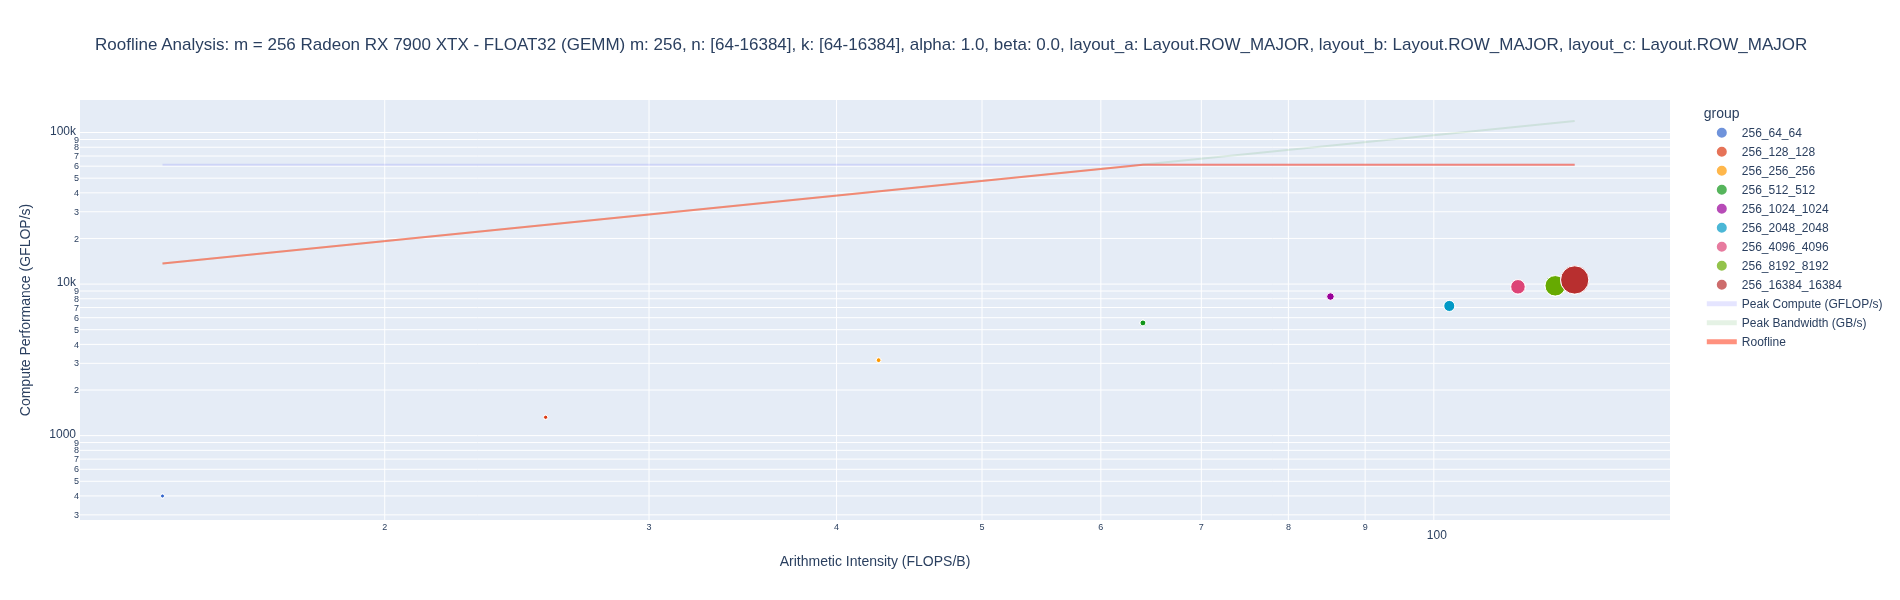

In [16]:
for d in figures:
    for _datatype, fig in d.items():
        fig.show()

## Advanced: Accessing the Roofline Data Directly

We can also access the raw data used to generate the roofline plots.

In [15]:
# Get the first result set for FLOAT16
result_set = results.get(DataType.FLOAT16.name, [])[0] if results else None

if result_set:
    # Calculate roofline data directly
    df = GemmPlotter.calculate_roofline_data(
        result_set=result_set
    )
    
    # Display the DataFrame
    display(df)
    
    # Show key metrics
    print(f"\nArithmetic Intensity Range: {df['arithmetic_intensity_value'].min()} to {df['arithmetic_intensity_value'].max()}")
    print(f"Performance Range (TFLOPS): {df['compute_performance_value'].min()} to {df['compute_performance_value'].max()}")
else:
    print("No results available to analyze")

shape: (44, 21)
┌─────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬─────────┬───────────┐
│ is_best ┆ latency_va ┆ latency_un ┆ memory_ban ┆ … ┆ memory_co ┆ memory_co ┆ group   ┆ attainabl │
│ ---     ┆ lue        ┆ it         ┆ dwidth_val ┆   ┆ nstraint_ ┆ nstraint_ ┆ ---     ┆ e_perform │
│ bool    ┆ ---        ┆ ---        ┆ ue         ┆   ┆ value     ┆ unit      ┆ str     ┆ ance_valu │
│         ┆ f64        ┆ str        ┆ ---        ┆   ┆ ---       ┆ ---       ┆         ┆ e         │
│         ┆            ┆            ┆ f64        ┆   ┆ f64       ┆ str       ┆         ┆ ---       │
│         ┆            ┆            ┆            ┆   ┆           ┆           ┆         ┆ f64       │
╞═════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═════════╪═══════════╡
│ false   ┆ 14.1661    ┆ μs         ┆ 0.596354   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 14.0325    ┆ μs         ┆ 0.602031   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 14.0957    ┆ μs         ┆ 0.599332   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 13.2229    ┆ μs         ┆ 0.638893   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 12.2989    ┆ μs         ┆ 0.686892   ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ …       ┆ …          ┆ …          ┆ …          ┆ … ┆ …         ┆ …         ┆ …       ┆ …         │
│ false   ┆ 5.47683    ┆ μs         ┆ 1.5425     ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 5.25323    ┆ μs         ┆ 1.60815    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 4.58723    ┆ μs         ┆ 1.84163    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ false   ┆ 6.33903    ┆ μs         ┆ 1.3327     ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
│ true    ┆ 3.48922    ┆ μs         ┆ 2.42117    ┆ … ┆ 930.90909 ┆ GB/s      ┆ 1_64_64 ┆ 930.90909 │
│         ┆            ┆            ┆            ┆   ┆ 1         ┆           ┆         ┆ 1         │
└─────────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴─────────┴───────────┘


Arithmetic Intensity Range: 0.9696969696969697 to 0.9696969696969697
Performance Range (TFLOPS): 0.578283 to 2.3478


## Summary

In this notebook, we've demonstrated:

1. How to configure and run a GEMM scan with different matrix dimensions
2. How to generate roofline plots using the GemmPlotter class
3. How to access and analyze the raw roofline data